In [2]:
import numpy as np
import xarray as xr
import scipy.signal as sg
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import patches
import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
import os

%load_ext autoreload
%autoreload 2
%matplotlib widget


In [3]:
# load session
session = DynamicRoutingSession('668755_2023-08-31')

In [4]:
trials=pd.read_parquet(
            npc_lims.get_cache_path('trials',session.id)
        )
        

units=pd.read_parquet(
            npc_lims.get_cache_path('units',session.id)
        )

In [4]:
performance=pd.read_parquet(
            npc_lims.get_cache_path('performance',session.id)
        )

In [5]:
performance

,start_time,stop_time,block_index,rewarded_modality,cross_modal_dprime,signed_cross_modal_dprime,same_modal_dprime,nonrewarded_modal_dprime,vis_intra_dprime,aud_intra_dprime,session_idx,date,subject_id,session_id
id,,,,,,,,,,,,,,
0,2460.26425,3058.18209,0,vis,1.192984,1.192984,3.829012,1.526119,3.829012,1.526119,0,2023-08-31,668755,668755_2023-08-31_0
1,3060.61747,3666.19180,1,aud,1.456523,-1.456523,2.375310,1.000318,1.000318,2.375310,0,2023-08-31,668755,668755_2023-08-31_0
2,3670.74554,4277.48748,2,vis,2.390691,2.390691,3.897895,1.529237,3.897895,1.529237,0,2023-08-31,668755,668755_2023-08-31_0
3,4279.25567,4884.93012,3,aud,1.889510,-1.889510,3.076341,0.721522,0.721522,3.076341,0,2023-08-31,668755,668755_2023-08-31_0
4,4885.38050,5494.07410,4,vis,1.684584,1.684584,3.219483,1.256495,3.219483,1.256495,0,2023-08-31,668755,668755_2023-08-31_0
5,5494.50779,6095.82857,5,aud,2.484364,-2.484364,2.439470,1.413531,1.413531,2.439470,0,2023-08-31,668755,668755_2023-08-31_0


In [5]:
#make trial aligned 3d spike tensor
time_before = 0.5
time_after = 1.0
binsize = 0.01
trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, time_before, time_after, binsize)

In [6]:
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'context_name', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_aud_stim',
       'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_context', 'is_aud_context', 'is_context_switch', 'is_repeat',
       'is_opto', 'session_idx', 'date', 'subject_id', 'session_id'],
      dtyp

In [7]:
#define trial types
response_viscontext_visstim = trials.query('is_response and is_vis_context and is_vis_target and not is_reward_scheduled')
response_viscontext_audstim = trials.query('is_response and is_vis_context and is_aud_target and not is_reward_scheduled')

response_audcontext_visstim = trials.query('is_response and is_aud_context and is_vis_target and not is_reward_scheduled')
response_audcontext_audstim = trials.query('is_response and is_aud_context and is_aud_target and not is_reward_scheduled')

# nonresponse_viscontext_visstim = trials.query('not is_response and is_vis_context and is_vis_target and not is_reward_scheduled') #very rare
nonresponse_viscontext_audstim = trials.query('not is_response and is_vis_context and is_aud_target and not is_reward_scheduled')

nonresponse_audcontext_visstim = trials.query('not is_response and is_aud_context and is_vis_target and not is_reward_scheduled')
# nonresponse_audcontext_audstim = trials.query('not is_response and is_aud_context and is_aud_target and not is_reward_scheduled') #very rare


In [8]:
trial_da.unit_id.values

array(['668755_2023-08-31_C-216', '668755_2023-08-31_C-503',
       '668755_2023-08-31_C-501', ..., '668755_2023-08-31_E-72',
       '668755_2023-08-31_D-178', '668755_2023-08-31_A-473'], dtype=object)

In [9]:
#normalize by mean FR and stdev per unit
trial_da_norm = trial_da.copy()

for unit in trial_da_norm.unit_id.values:
    unit_data = trial_da_norm.sel(unit_id=unit)
    mean_fr = unit_data.sel(time=slice(-0.2,0)).mean(dim=['time','trials']).values
    std_fr = unit_data.sel(time=slice(-0.2,0)).mean(dim=['time']).std(dim=['trials']).values
    trial_da_norm.loc[{'unit_id':unit}] = (unit_data - mean_fr) / std_fr


In [10]:
#make a concatenated array of all conditions for each unit
unit_ids=[]
concat_psths=[]

for unit in trial_da_norm.unit_id.values:
    unit_ids.append(unit)
    unit_data = trial_da_norm.sel(unit_id=unit)

    response_viscontext_visstim_psth=unit_data.sel(trials=response_viscontext_visstim.index).mean(dim='trials').values
    response_viscontext_audstim_psth=unit_data.sel(trials=response_viscontext_audstim.index).mean(dim='trials').values
    response_audcontext_visstim_psth=unit_data.sel(trials=response_audcontext_visstim.index).mean(dim='trials').values
    response_audcontext_audstim_psth=unit_data.sel(trials=response_audcontext_audstim.index).mean(dim='trials').values
    nonresponse_viscontext_audstim_psth=unit_data.sel(trials=nonresponse_viscontext_audstim.index).mean(dim='trials').values
    nonresponse_audcontext_visstim_psth=unit_data.sel(trials=nonresponse_audcontext_visstim.index).mean(dim='trials').values

    combined_psth=np.hstack([response_viscontext_visstim_psth,response_viscontext_audstim_psth,response_audcontext_visstim_psth,response_audcontext_audstim_psth,nonresponse_viscontext_audstim_psth,nonresponse_audcontext_visstim_psth])
    
    concat_psths.append(combined_psth)

concat_psths = np.vstack(concat_psths)

In [11]:
concat_psths[0,:].shape

(894,)

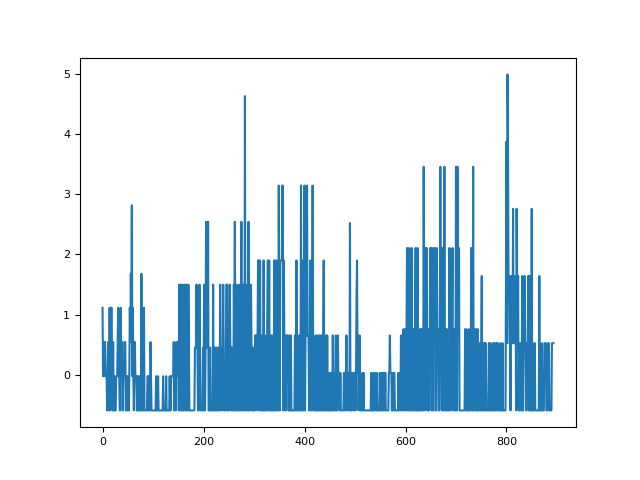

In [25]:
fig,ax=plt.subplots()
ax.plot(concat_psths[60,:])

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree


In [14]:
complete_clustering = linkage(concat_psths.T, method="complete", metric="euclidean")
average_clustering = linkage(concat_psths.T, method="average", metric="euclidean")
single_clustering = linkage(concat_psths.T, method="single", metric="euclidean")

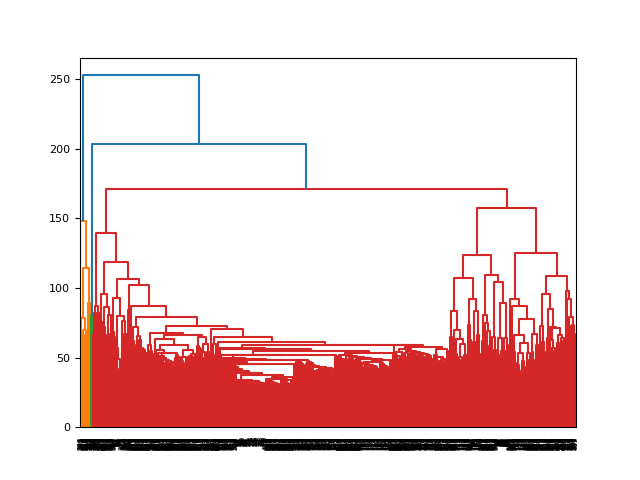

In [15]:
fig,ax=plt.subplots()
dendrogram(complete_clustering)
plt.show()

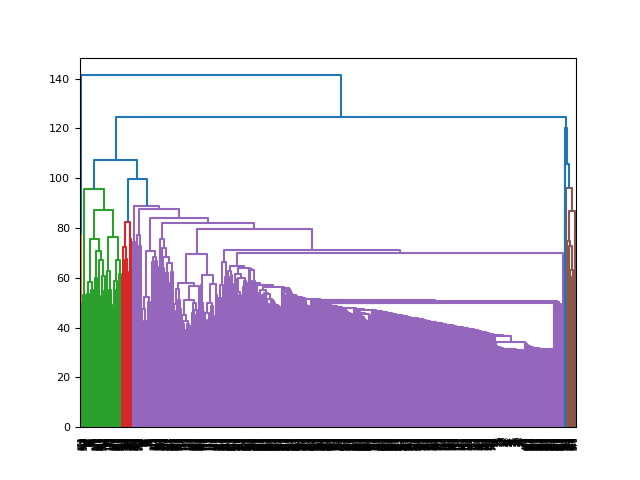

In [16]:
fig,ax=plt.subplots()
dendrogram(average_clustering)
plt.show()

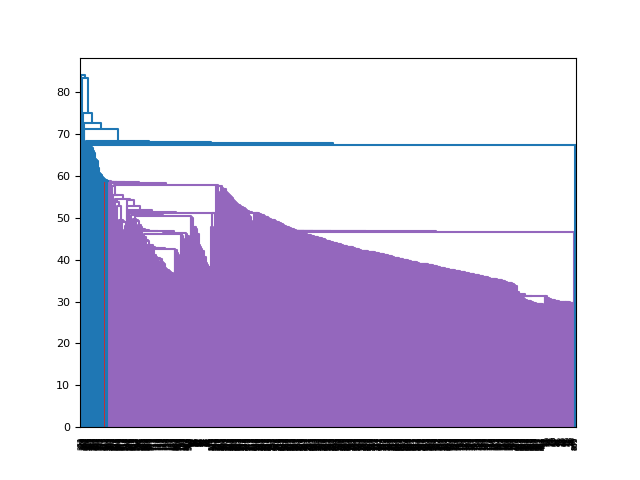

In [17]:
fig,ax=plt.subplots()
dendrogram(single_clustering)
plt.show()

In [18]:
cluster_labels = cut_tree(average_clustering, n_clusters=10).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
units['structure'].unique()

array(['ACAd', 'ACAv', 'AON', 'CP', 'DP', 'FRP', 'HPF', 'LGv', 'MB',
       'MOp', 'MOs', 'MPT', 'NPC', 'OLF', 'ORBl', 'PAG', 'PPT', 'RSPagl',
       'RSPd', 'RSPv', 'SCdg', 'SCdw', 'SCig', 'SCiw', 'SCop', 'SCsg',
       'SSp', 'TTd', 'VISam', 'VISp', 'VISpm', 'ccg', 'dhc', 'fa', 'fp',
       'root', 'scwm'], dtype=object)

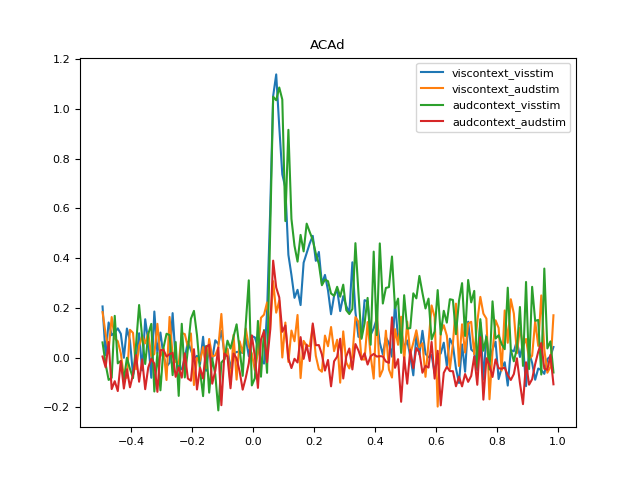

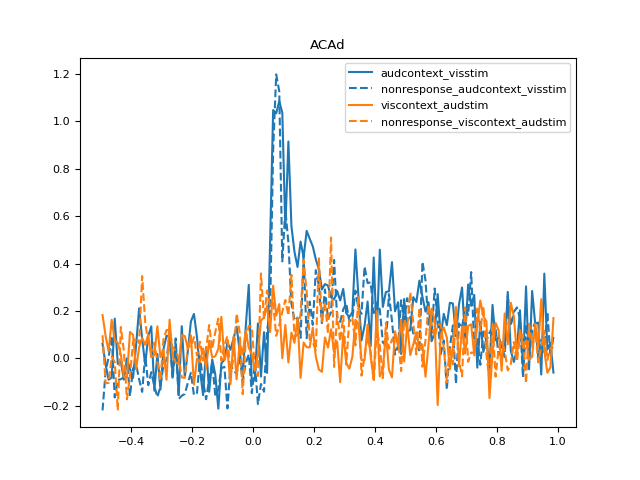

In [20]:
sel_area='ACAd'

response_viscontext_visstim_mean=trial_da_norm.sel(
    trials=response_viscontext_visstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])
response_viscontext_audstim_mean=trial_da_norm.sel(
    trials=response_viscontext_audstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])

response_audcontext_visstim_mean=trial_da_norm.sel(
    trials=response_audcontext_visstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])
response_audcontext_audstim_mean=trial_da_norm.sel(
    trials=response_audcontext_audstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])

nonresponse_viscontext_audstim_mean=trial_da_norm.sel(
    trials=nonresponse_viscontext_audstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])
nonresponse_audcontext_visstim_mean=trial_da_norm.sel(
    trials=nonresponse_audcontext_visstim.index,
    unit_id=units.query('structure.str.contains(@sel_area)')['unit_id'].values
    ).mean(dim=['trials','unit_id'])


# fig,ax=plt.subplots(2,1)
# ax[0].plot(response_viscontext_visstim_mean.time,response_viscontext_visstim_mean)
# ax[0].plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean)

# ax[1].plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean)
# ax[1].plot(response_audcontext_audstim_mean.time,response_audcontext_audstim_mean)

fig,ax=plt.subplots(1,1)
ax.plot(response_viscontext_visstim_mean.time,response_viscontext_visstim_mean,label='viscontext_visstim')
ax.plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean,label='viscontext_audstim')
ax.plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean,label='audcontext_visstim')
ax.plot(response_audcontext_audstim_mean.time,response_audcontext_audstim_mean,label='audcontext_audstim')

ax.set_title(sel_area)
ax.legend()

fig,ax=plt.subplots(1,1)
ax.plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean,label='audcontext_visstim',color='tab:blue')
ax.plot(nonresponse_audcontext_visstim_mean.time,nonresponse_audcontext_visstim_mean,label='nonresponse_audcontext_visstim',color='tab:blue',linestyle='--')
ax.plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean,label='viscontext_audstim',color='tab:orange')
ax.plot(nonresponse_viscontext_audstim_mean.time,nonresponse_viscontext_audstim_mean,label='nonresponse_viscontext_audstim',color='tab:orange',linestyle='--')


ax.set_title(sel_area)
ax.legend()

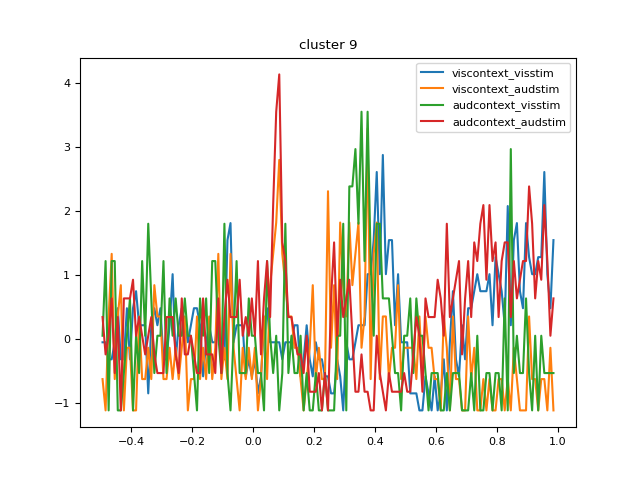

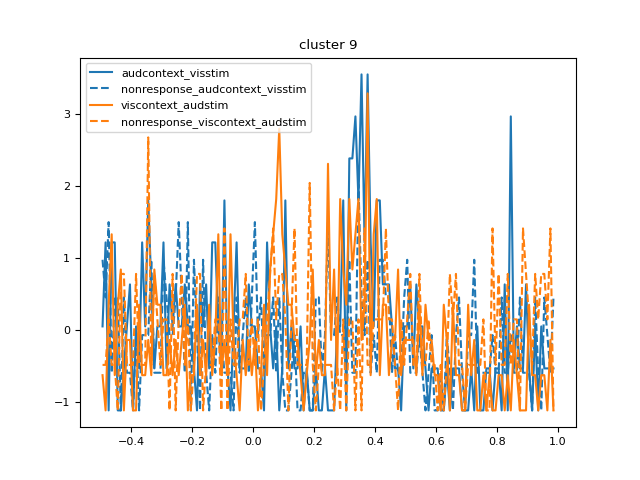

In [21]:
sel_cluster=9

response_viscontext_visstim_mean=trial_da_norm.sel(
    trials=response_viscontext_visstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])
response_viscontext_audstim_mean=trial_da_norm.sel(
    trials=response_viscontext_audstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])

response_audcontext_visstim_mean=trial_da_norm.sel(
    trials=response_audcontext_visstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])
response_audcontext_audstim_mean=trial_da_norm.sel(
    trials=response_audcontext_audstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])

nonresponse_viscontext_audstim_mean=trial_da_norm.sel(
    trials=nonresponse_viscontext_audstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])
nonresponse_audcontext_visstim_mean=trial_da_norm.sel(
    trials=nonresponse_audcontext_visstim.index,
    unit_id=units['unit_id'].iloc[np.where(cluster_labels==sel_cluster)[0]].values
    ).mean(dim=['trials','unit_id'])


# fig,ax=plt.subplots(2,1)
# ax[0].plot(response_viscontext_visstim_mean.time,response_viscontext_visstim_mean)
# ax[0].plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean)

# ax[1].plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean)
# ax[1].plot(response_audcontext_audstim_mean.time,response_audcontext_audstim_mean)

fig,ax=plt.subplots(1,1)
ax.plot(response_viscontext_visstim_mean.time,response_viscontext_visstim_mean,label='viscontext_visstim')
ax.plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean,label='viscontext_audstim')
ax.plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean,label='audcontext_visstim')
ax.plot(response_audcontext_audstim_mean.time,response_audcontext_audstim_mean,label='audcontext_audstim')

ax.set_title('cluster '+str(sel_cluster))
ax.legend()

fig,ax=plt.subplots(1,1)
ax.plot(response_audcontext_visstim_mean.time,response_audcontext_visstim_mean,label='audcontext_visstim',color='tab:blue')
ax.plot(nonresponse_audcontext_visstim_mean.time,nonresponse_audcontext_visstim_mean,label='nonresponse_audcontext_visstim',color='tab:blue',linestyle='--')
ax.plot(response_viscontext_audstim_mean.time,response_viscontext_audstim_mean,label='viscontext_audstim',color='tab:orange')
ax.plot(nonresponse_viscontext_audstim_mean.time,nonresponse_viscontext_audstim_mean,label='nonresponse_viscontext_audstim',color='tab:orange',linestyle='--')


ax.set_title('cluster '+str(sel_cluster))
ax.legend()

In [22]:
#cluster all units together?

#loop through sessions

#make xarray and normalize

#sort my trial type

#append to mega unit metadata table

#append to all unit psth array

###try simplified unit array - stim responses, context baseline diff, response diff, etc.


In [23]:
#other metrics:

#pct change in FR due to:
#context
#each stimulus
#a lick (lick-aligned xarray?)

#plot distribution in each area
#or plot on CCF